### 0. Splitting Greenland into UTM grid zones and save tiles to shapefile

Splitting a big continent into many tiles may be challenging because every projection has its own distortion. To produce dataset that will be accurate to the details over large area, it is necessary to apply many local projection. That is why UTM CRS was created for. To provide the best accuracy the tiles should be divided accordingly to the UTM zones and possibly, smaller are better because they can fit better in the grid of zones.


###### From documentation:

"When dealing with large areas such as countries or continents spanning multiple UTM zones, it might be convenient to split the area according to UTM zones or to the UTM Military Grid Reference System. For these use-cases, a UtmZoneSplitter and a UtmGridSplitter have been created. These splitters will generate a list of bounding boxes in UTM CRS. Each BBox will have the CRS corresponding to the UTM zone it belongs to.

To ensure consistency across zones and grid tiles, the size of the BBoxes in metres is specified as input parameter. For this reason, the option reduce_bbox_sizes is not available for these splitters. The two splitters return consistent results between each other, with the exceptions of areas where the UTM grid tiles present exceptions, as in 31V and 32V, and 31X, 33X, 35X and 37X."

### Load necessary libraries:

In [1]:
import os
import geopandas as gpd
from sentinelhub import CRS
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape

from sentinelhub import UtmZoneSplitter 
from shapely.geometry import Polygon

### Obtain the outline of Greenland:

In [2]:
# Folder where Greenland outline data is stored:
DATA_FOLDER = os.path.join('..', '..', 'data', 'geoJSONs')

# Load geojson file:
grl_geo_json = gpd.read_file(os.path.join(DATA_FOLDER, 'GRL.geojson'))

# Check what crs is obtained outline:
grl_geo_json.crs

{'init': 'epsg:4326'}

###### Choice of CRS and preview:
EPSG:4326 is just the EPSG identifier of WGS84 - therefore we are going to apply WGS84 GSR

Dimension of the area is 62N x 24W degrees


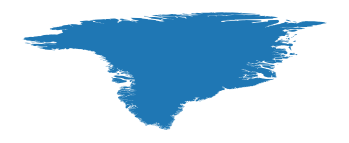

In [3]:
CHOSEN_CRS = CRS.WGS84

# create a shape file:
greenalnd_shape = np.asarray(grl_geo_json.geometry)[-1]

# Plot country in a chosen CRS:
grl_geo_json.plot()
plt.axis('off');

print('Dimension of the area is {0:.0f}N x {1:.0f}W degrees'.format(greenalnd_shape.bounds[2] - greenalnd_shape.bounds[0],
                                                                greenalnd_shape.bounds[3] - greenalnd_shape.bounds[1] ))

### 2. Divide the Area-of-Interest (AOI):

We are able here to choose one of 4 predefined sizes of patches.

In [4]:
greenland_area = shape(greenalnd_shape)

BIG_TILES = 0
MEDIUM_TILES = 1
SMALL_TILES = 2
MINI_TILES = 3

tile_sizes = [100000,50000,25000,10000]

#PICK TILE SIZE HERE:
TILE_SIZE = tile_sizes[MINI_TILES]

utm_zone_splitter = UtmZoneSplitter([greenland_area], CHOSEN_CRS, (TILE_SIZE, TILE_SIZE))

In [5]:
print( 'There is ', str(len(utm_zone_splitter.get_bbox_list())), 'of patches in total with different CRS') # How many tiles do we have?

utm_zone_splitter.get_bbox_list()[:25]

There is  24381 of patches in total with different CRS


[BBox(((540000.0, 8670000.0), (550000.0, 8680000.0)), crs=EPSG:32618),
 BBox(((540000.0, 8680000.0), (550000.0, 8690000.0)), crs=EPSG:32618),
 BBox(((540000.0, 8690000.0), (550000.0, 8700000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8590000.0), (560000.0, 8600000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8660000.0), (560000.0, 8670000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8670000.0), (560000.0, 8680000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8680000.0), (560000.0, 8690000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8690000.0), (560000.0, 8700000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8700000.0), (560000.0, 8710000.0)), crs=EPSG:32618),
 BBox(((550000.0, 8710000.0), (560000.0, 8720000.0)), crs=EPSG:32618),
 BBox(((560000.0, 8580000.0), (570000.0, 8590000.0)), crs=EPSG:32618),
 BBox(((560000.0, 8590000.0), (570000.0, 8600000.0)), crs=EPSG:32618),
 BBox(((560000.0, 8650000.0), (570000.0, 8660000.0)), crs=EPSG:32618),
 BBox(((560000.0, 8660000.0), (570000.0, 8670000.0)), crs=EPSG:32618),
 BBox(

In [6]:
bboxs_list = [bbox for bbox in utm_zone_splitter.bbox_list]
bboxs_list_unified_crs = [bbox.transform(CHOSEN_CRS) for bbox in utm_zone_splitter.bbox_list]
crs_list = [bbox.crs for bbox in utm_zone_splitter.bbox_list]
idxs_x = [info['index_x'] for info in utm_zone_splitter.info_list]
idxs_y = [info['index_y'] for info in utm_zone_splitter.info_list]
index = [info['index'] for info in utm_zone_splitter.info_list]
utm_zone = [info['utm_zone'] for info in utm_zone_splitter.info_list]
utm_zone_splitter.info_list[:2]

[{'crs': 'UTM_18N',
  'utm_zone': '18',
  'utm_row': '',
  'direction': 'N',
  'index': 0,
  'index_x': 0,
  'index_y': 9},
 {'crs': 'UTM_18N',
  'utm_zone': '18',
  'utm_row': '',
  'direction': 'N',
  'index': 1,
  'index_x': 0,
  'index_y': 10}]


###### Seperate indexes from different UMT zones and find theirs border idxs:

In [7]:
utm_zones_of_grl =[CRS.UTM_18N, CRS.UTM_19N, CRS.UTM_20N, CRS.UTM_21N, CRS.UTM_22N, CRS.UTM_23N, CRS.UTM_24N, CRS.UTM_25N, 
                   CRS.UTM_26N, CRS.UTM_27N, CRS.UTM_28N, CRS.UTM_29N, CRS.WGS84]

all_bboxs_idxs_utm_dict = {}
all_bboxs_x_idxs_utm_dict = {}
all_bboxs_y_idxs_utm_dict = {}
min_bboxs_idxs_utm_dict = {}
max_bboxs_idxs_utm_dict = {}

# for all of them at once:


# for each of the zones seperately :
for utm_zone in utm_zones_of_grl:
    utm_zone = utm_zone.name
    all_bboxs_idxs_utm_dict[utm_zone] = [ info['index'] for info in utm_zone_splitter.info_list if info['crs']==utm_zone]
    all_bboxs_x_idxs_utm_dict[utm_zone] = [ info['index_x'] for info in utm_zone_splitter.info_list if info['crs']==utm_zone]
    all_bboxs_y_idxs_utm_dict[utm_zone] = [ info['index_y'] for info in utm_zone_splitter.info_list if info['crs']==utm_zone]
    if utm_zone == CHOSEN_CRS.name:
        all_bboxs_idxs_utm_dict[CHOSEN_CRS.name] = [ info['index'] for info in utm_zone_splitter.info_list ]
        all_bboxs_x_idxs_utm_dict[CHOSEN_CRS.name] = [ info['index_x'] for info in utm_zone_splitter.info_list ]
        all_bboxs_y_idxs_utm_dict[CHOSEN_CRS.name] = [ info['index_y'] for info in utm_zone_splitter.info_list ]
    min_bboxs_idxs_utm_dict[utm_zone] = min(all_bboxs_idxs_utm_dict[utm_zone])
    max_bboxs_idxs_utm_dict[utm_zone] = max(all_bboxs_idxs_utm_dict[utm_zone])
    
# to check how many patches for each zone we have:
for key in all_bboxs_idxs_utm_dict.keys():
    print(key, str(len(all_bboxs_idxs_utm_dict[key])),'min:',min_bboxs_idxs_utm_dict[key],'max:',max_bboxs_idxs_utm_dict[key])

UTM_18N 23 min: 0 max: 22
UTM_19N 448 min: 23 max: 470
UTM_20N 813 min: 471 max: 1283
UTM_21N 1511 min: 1284 max: 2794
UTM_22N 4253 min: 2795 max: 7047
UTM_23N 5524 min: 7048 max: 12571
UTM_24N 4018 min: 12572 max: 16589
UTM_25N 3274 min: 16590 max: 19863
UTM_26N 2773 min: 19864 max: 22636
UTM_27N 1550 min: 22637 max: 24186
UTM_28N 187 min: 24187 max: 24373
UTM_29N 7 min: 24374 max: 24380
WGS84 24381 min: 0 max: 24380


###### Seperate Bboxes from different UMT zones:

In [8]:
all_bboxs_utm_dict = {}

for utm_zone in utm_zones_of_grl:
    all_bboxs_utm_dict[utm_zone.name] = bboxs_list[min_bboxs_idxs_utm_dict[utm_zone.name]:max_bboxs_idxs_utm_dict[utm_zone.name]+1]
    if utm_zone == CHOSEN_CRS:
        all_bboxs_utm_dict[utm_zone.name] = bboxs_list_unified_crs[min_bboxs_idxs_utm_dict[utm_zone.name]:max_bboxs_idxs_utm_dict[utm_zone.name]+1]
# to check how many patches for each zone we have:
for key in all_bboxs_utm_dict.keys():
    print(key, str(len(all_bboxs_utm_dict[key])),'min:',min_bboxs_idxs_utm_dict[key],'max:',max_bboxs_idxs_utm_dict[key])

UTM_18N 23 min: 0 max: 22
UTM_19N 448 min: 23 max: 470
UTM_20N 813 min: 471 max: 1283
UTM_21N 1511 min: 1284 max: 2794
UTM_22N 4253 min: 2795 max: 7047
UTM_23N 5524 min: 7048 max: 12571
UTM_24N 4018 min: 12572 max: 16589
UTM_25N 3274 min: 16590 max: 19863
UTM_26N 2773 min: 19864 max: 22636
UTM_27N 1550 min: 22637 max: 24186
UTM_28N 187 min: 24187 max: 24373
UTM_29N 7 min: 24374 max: 24380
WGS84 24381 min: 0 max: 24380


In [9]:
all_bboxs_utm_dict['UTM_29N']

[BBox(((440000.0, 9030000.0), (450000.0, 9040000.0)), crs=EPSG:32629),
 BBox(((440000.0, 9040000.0), (450000.0, 9050000.0)), crs=EPSG:32629),
 BBox(((450000.0, 9030000.0), (460000.0, 9040000.0)), crs=EPSG:32629),
 BBox(((450000.0, 9040000.0), (460000.0, 9050000.0)), crs=EPSG:32629),
 BBox(((450000.0, 9050000.0), (460000.0, 9060000.0)), crs=EPSG:32629),
 BBox(((450000.0, 9060000.0), (460000.0, 9070000.0)), crs=EPSG:32629),
 BBox(((460000.0, 9040000.0), (470000.0, 9050000.0)), crs=EPSG:32629)]

### 3. Display each zone seperately together with corresponding patches:

In [10]:
#produce patches:
all_patches_utm_dict = {}

for utm_zone in utm_zones_of_grl:
     all_patches_utm_dict[utm_zone.name] = [Polygon(bbox.get_polygon()) for bbox in all_bboxs_utm_dict[utm_zone.name]]

In [11]:
def display_greenland_with_patches_by_utm_zone(grl_geo_json, bboxs_idxs_dict , patches_utm_dict , crs_zone):
    gdf = gpd.GeoDataFrame({'index': bboxs_idxs_dict[crs_zone.name]},
                       crs=crs_zone, 
                       geometry=patches_utm_dict[crs_zone.name])
    grl_geo_json = grl_geo_json.to_crs(crs={'init': CRS.ogc_string(crs_zone)})
    
    fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

    # figure
    fig, ax = plt.subplots(figsize=(20, 20))
    gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
    #title(crs_zone.name, 'of Greenland')
    grl_geo_json.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
    plt.title(crs_zone.name + 'zone of Greenland')
    plt.axis('on')
    return

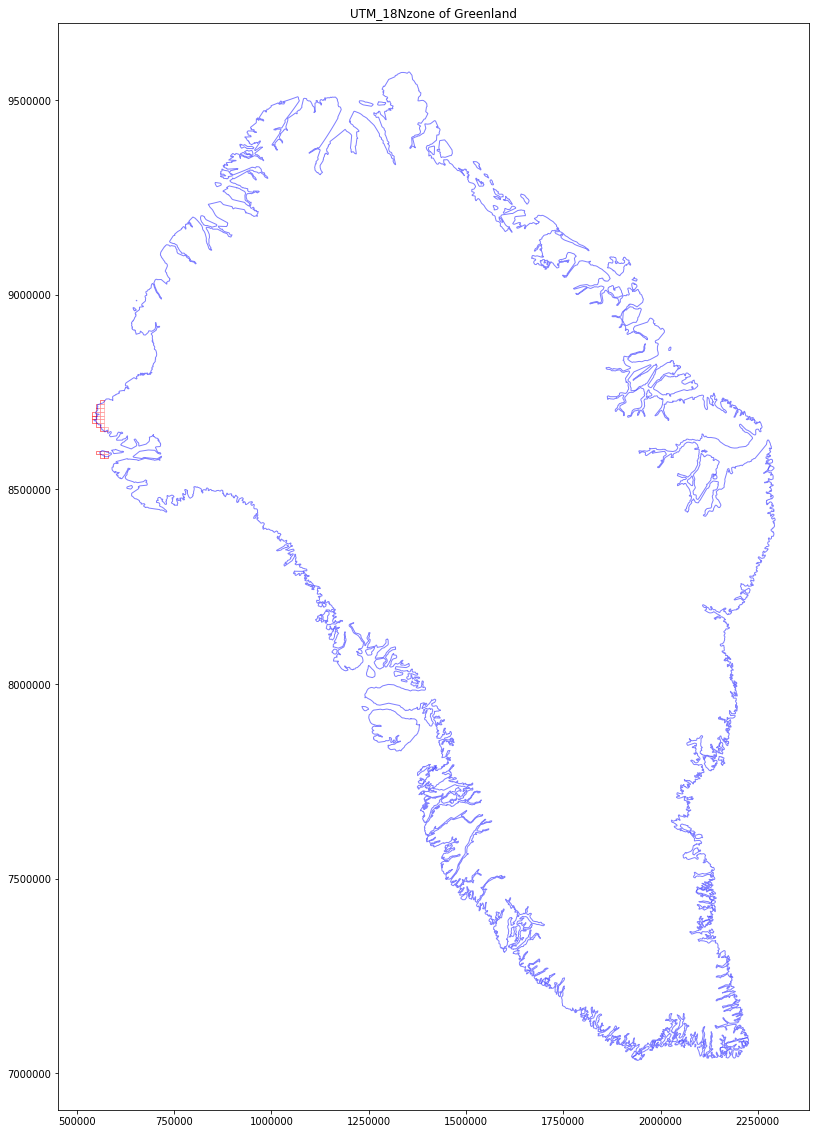

In [12]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_18N)

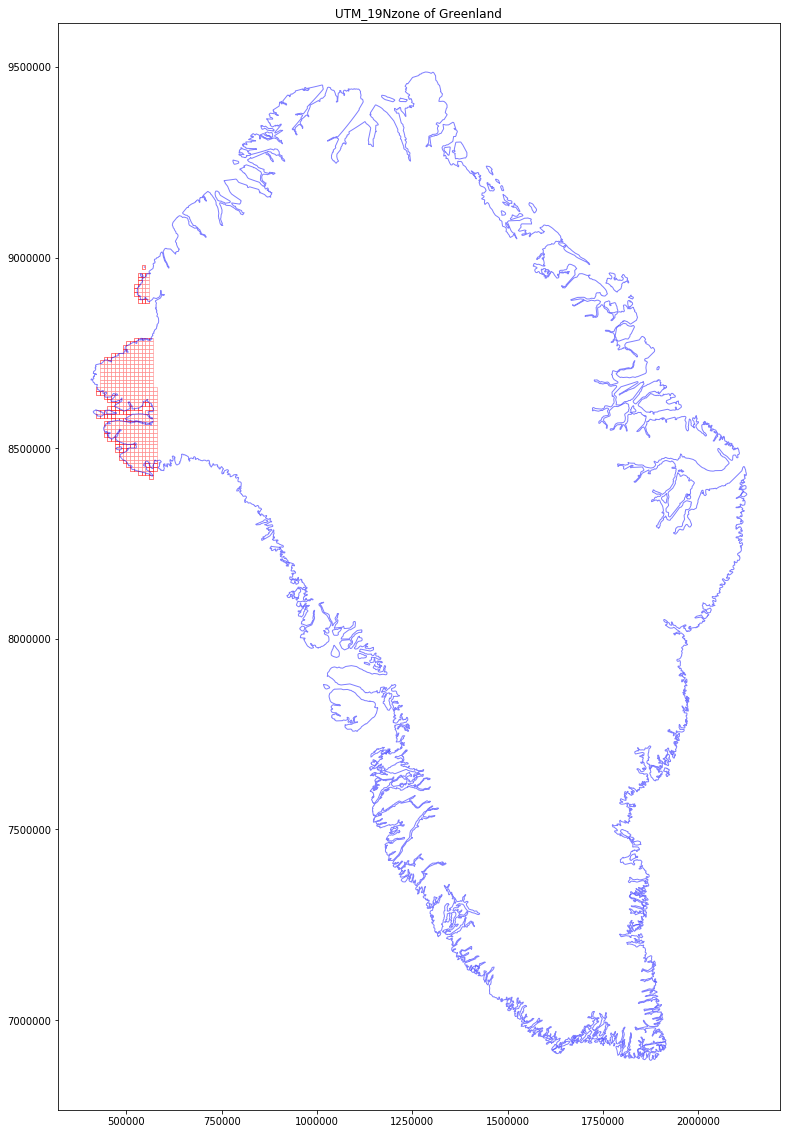

In [13]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_19N)

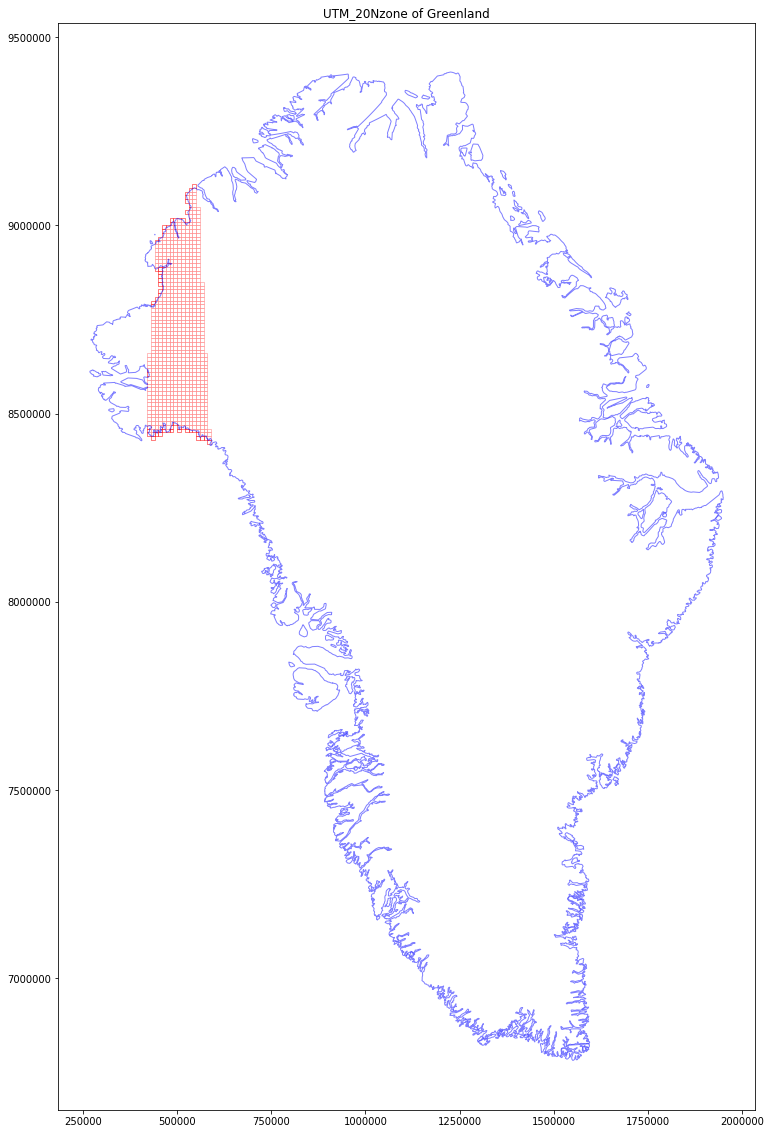

In [14]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_20N)

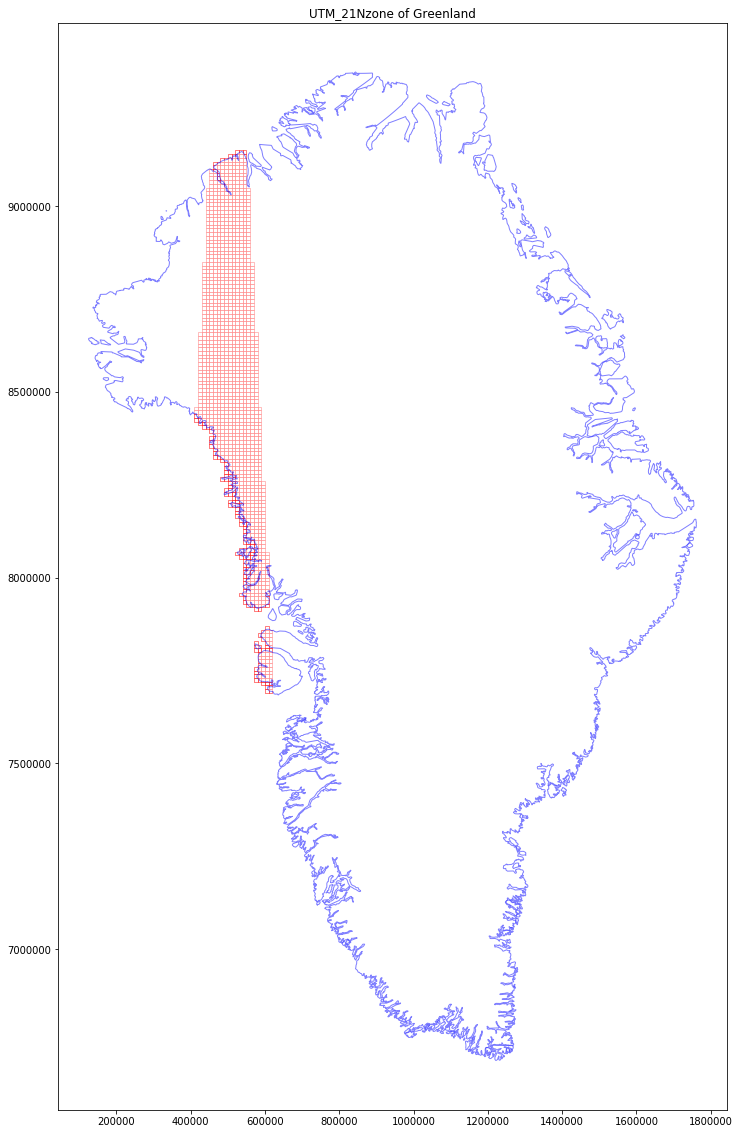

In [15]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_21N)

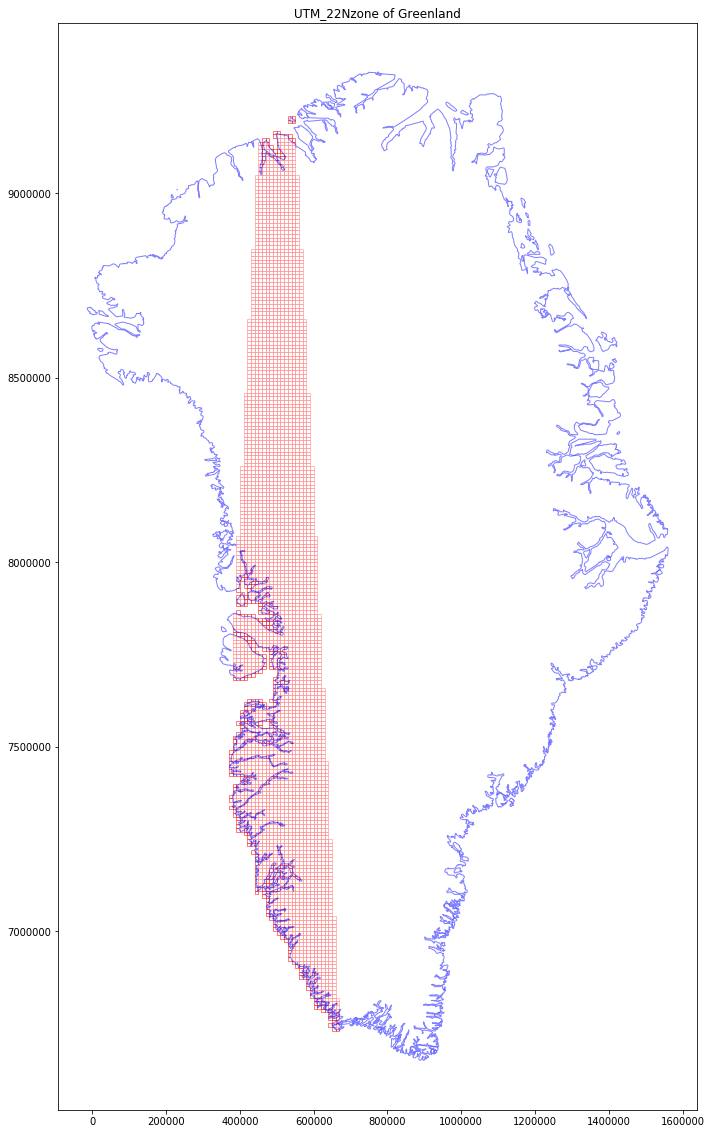

In [16]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_22N)

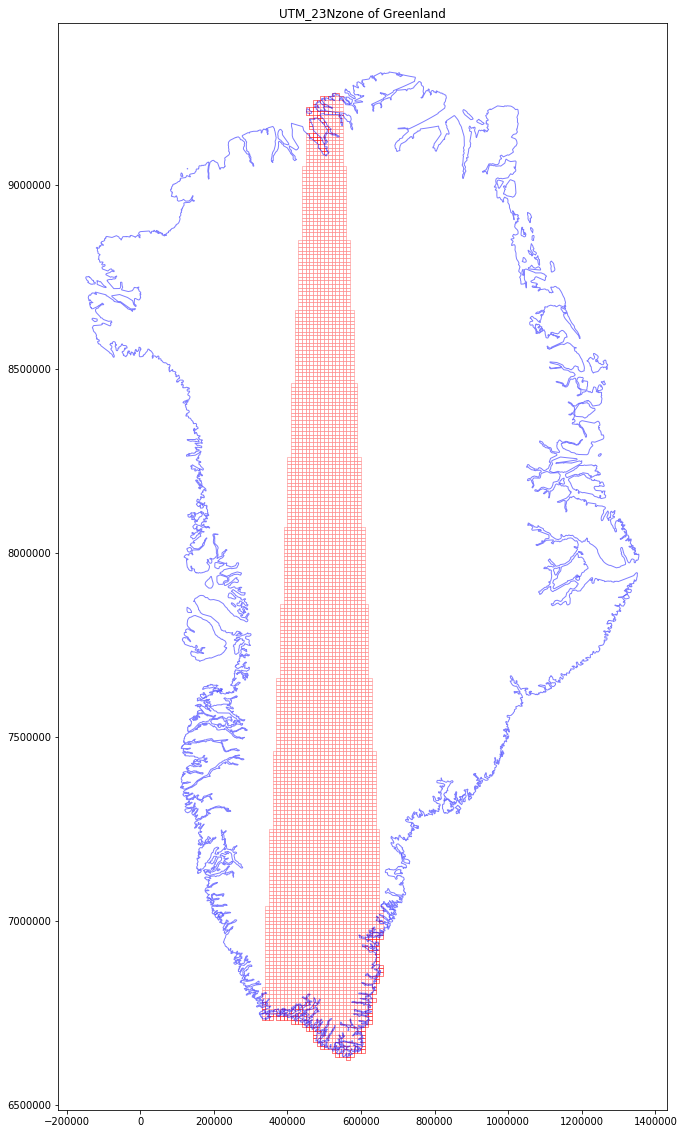

In [17]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_23N)

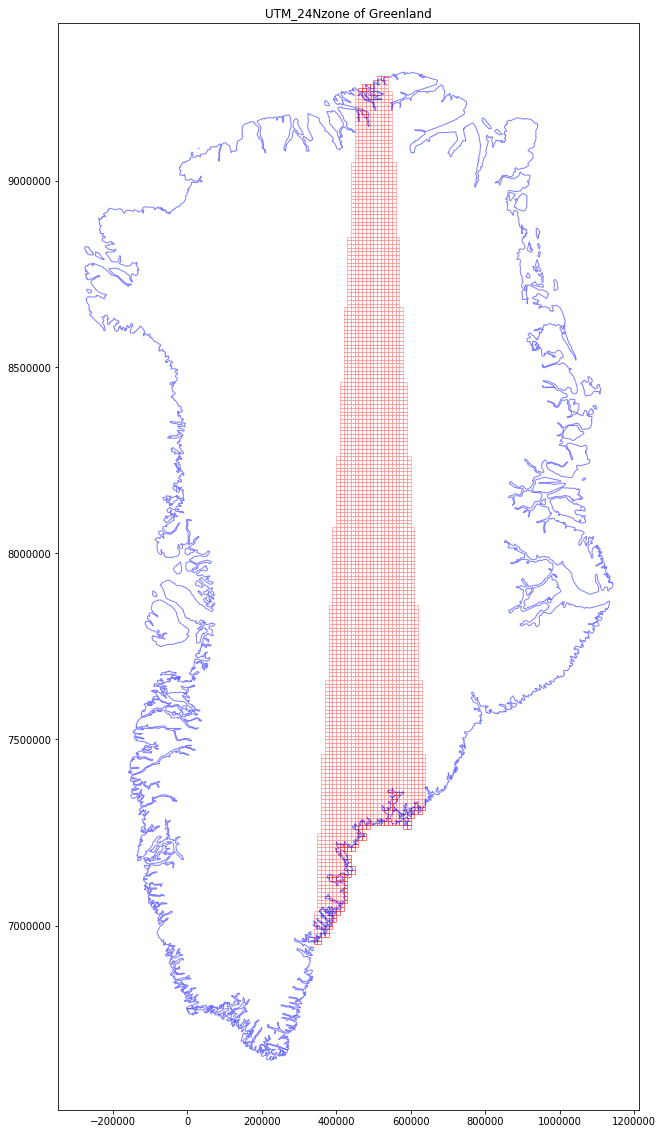

In [18]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_24N)

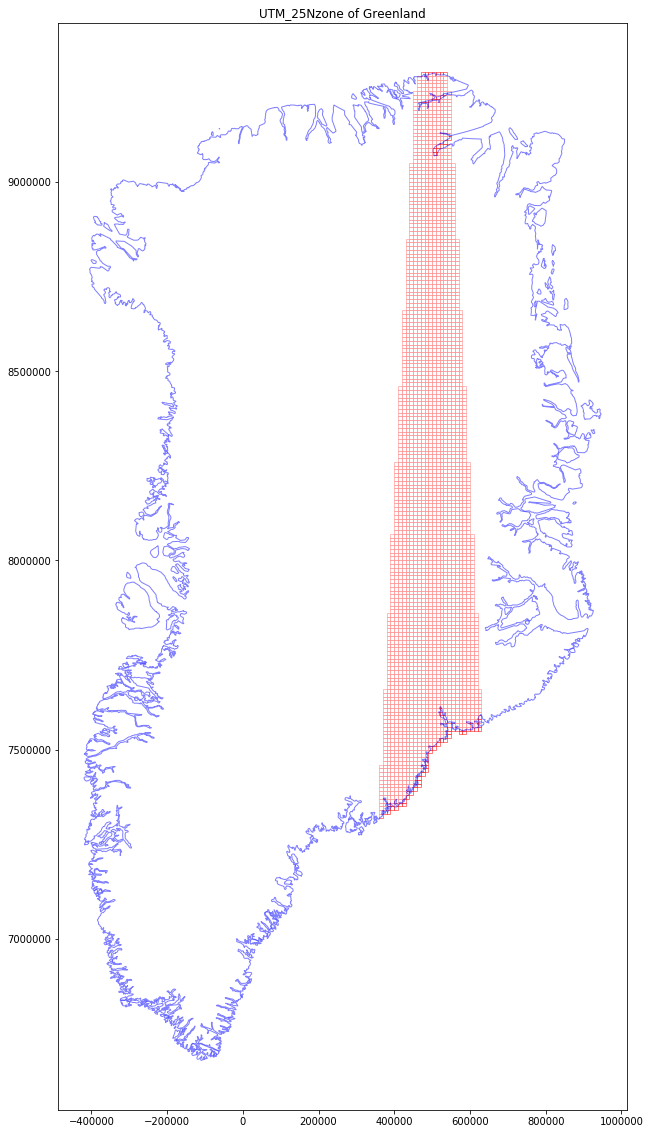

In [19]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_25N)

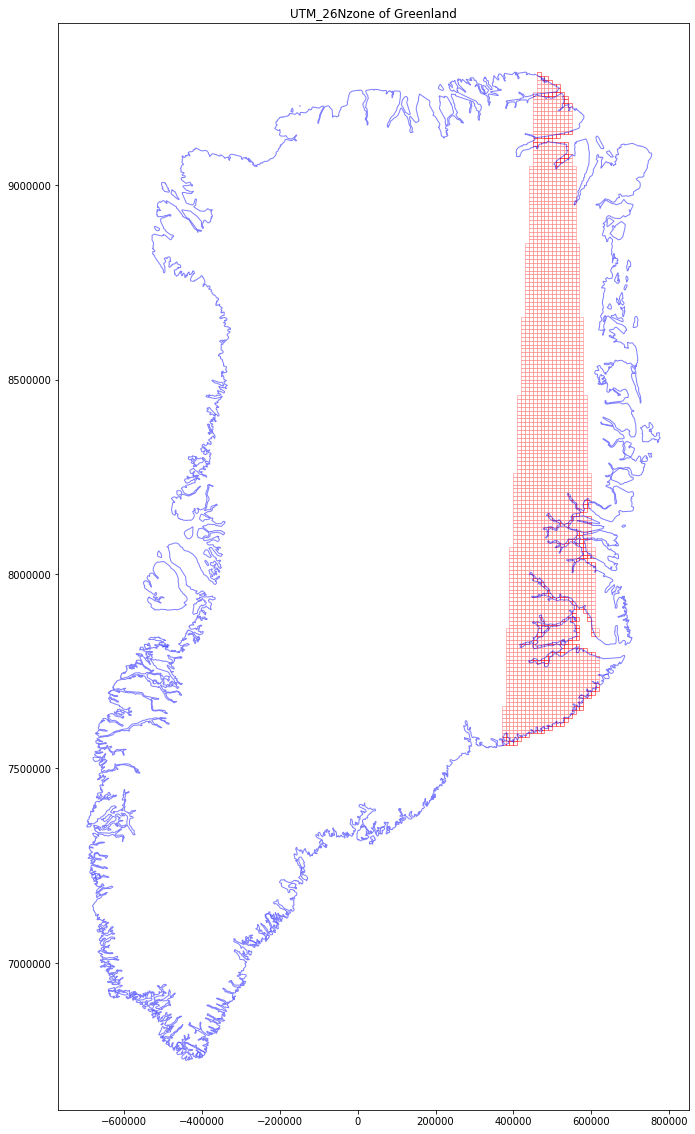

In [20]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_26N)

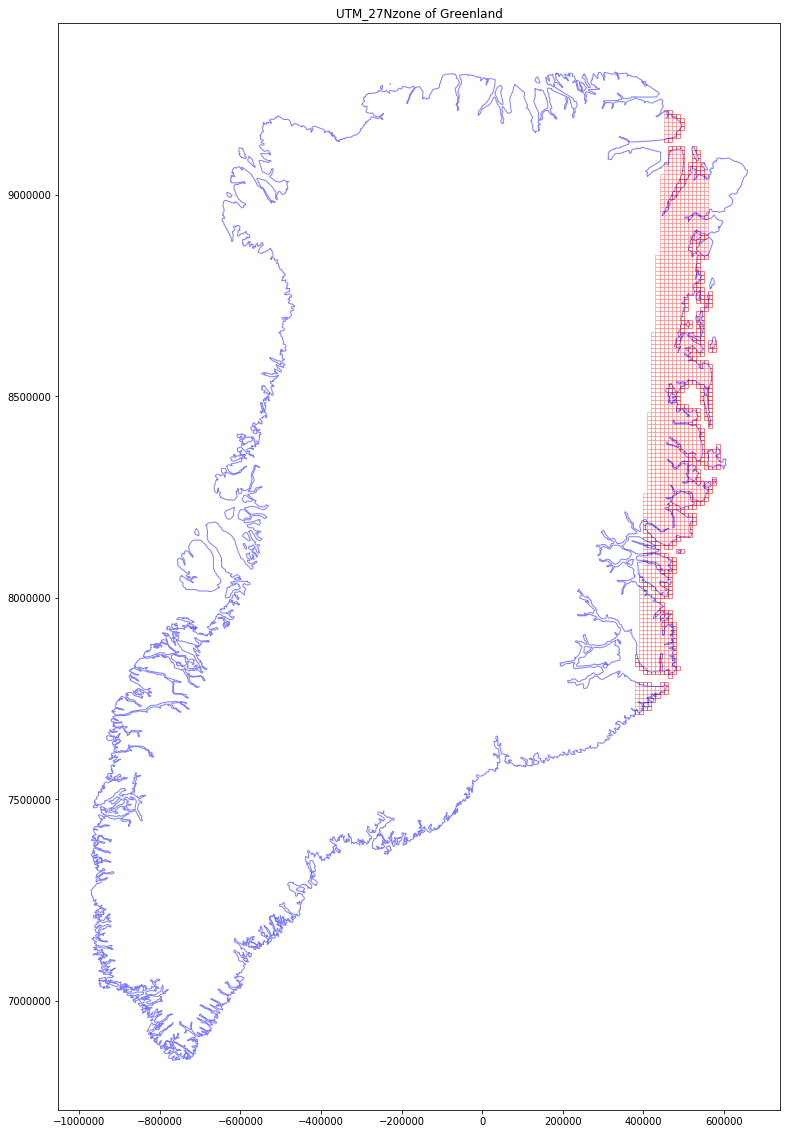

In [21]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_27N)

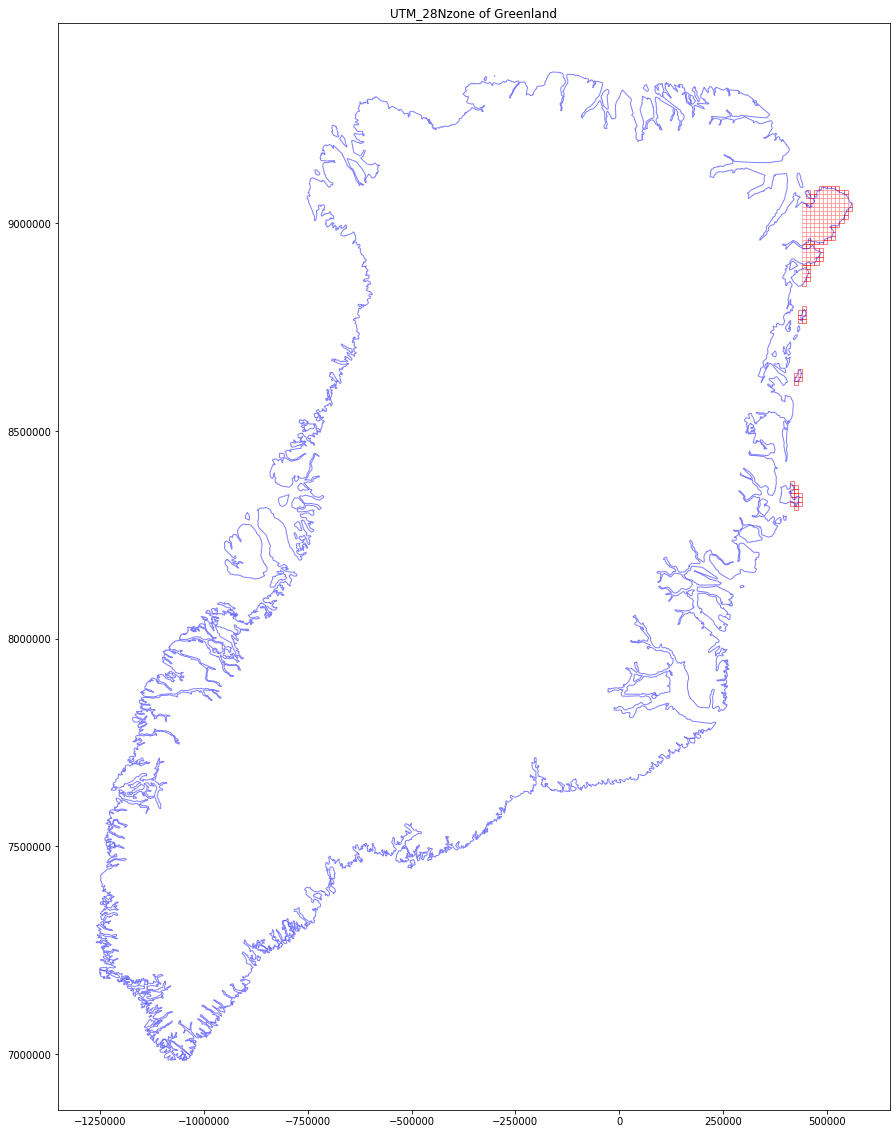

In [22]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict,all_patches_utm_dict, CRS.UTM_28N)

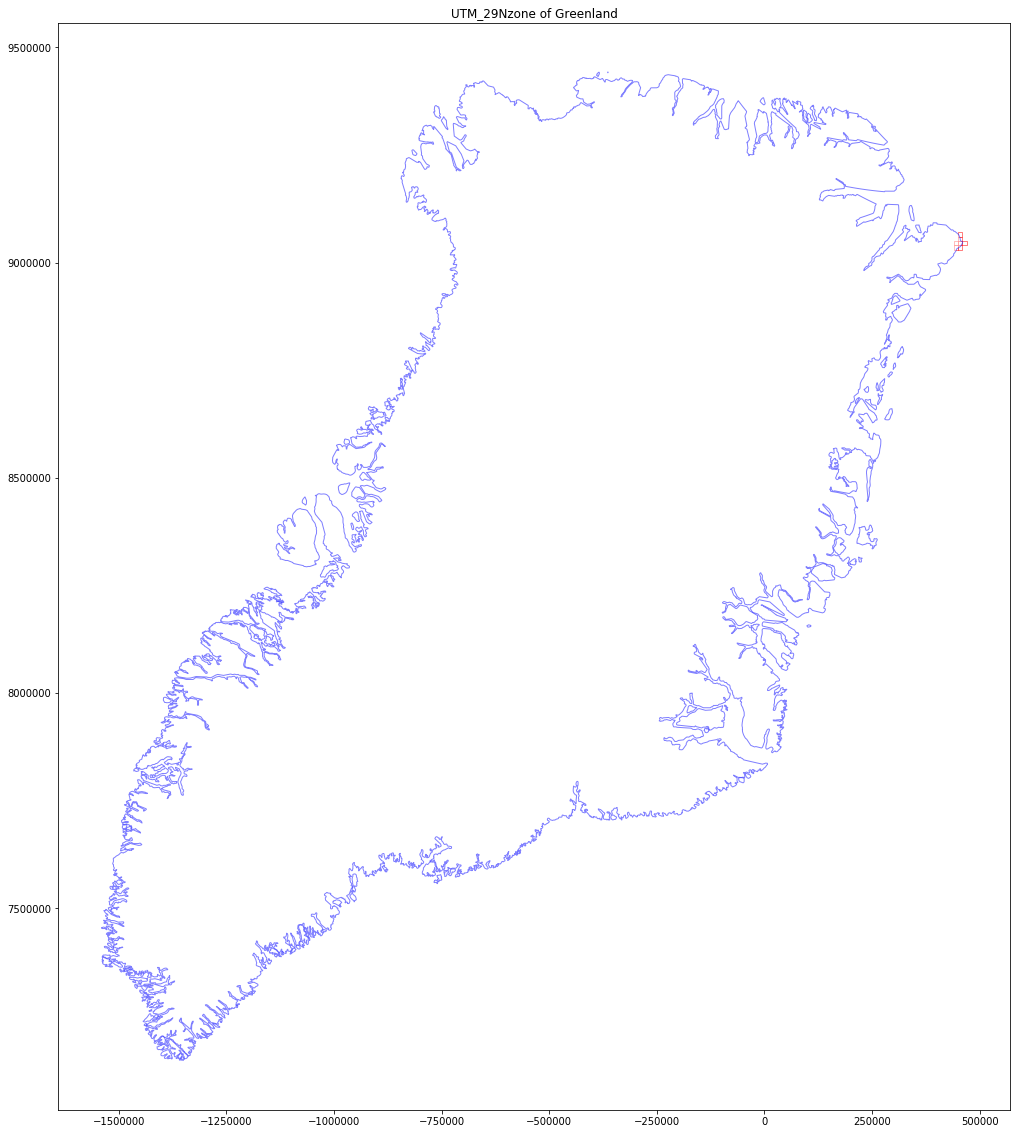

In [23]:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict, all_patches_utm_dict, CRS.UTM_29N)

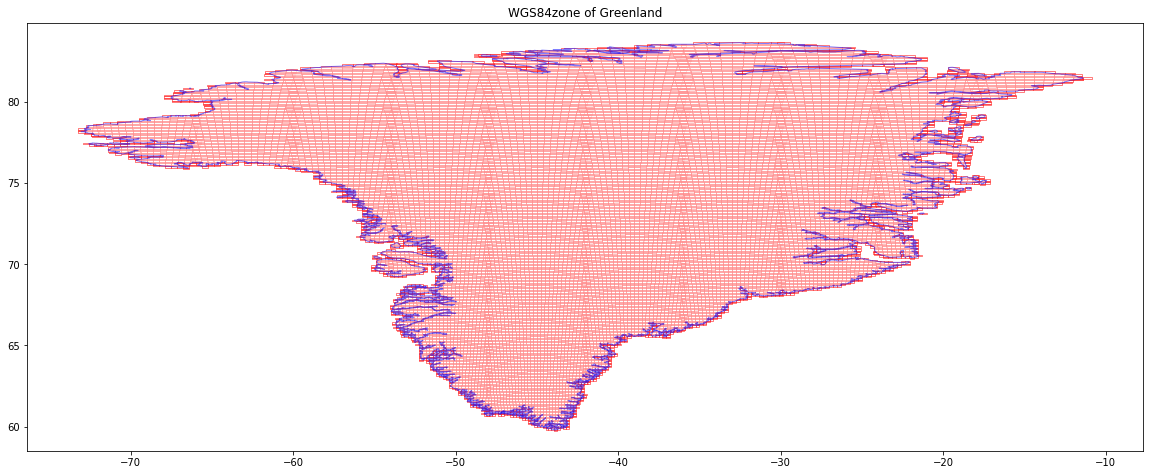

In [24]:
# this picture tiles may be overlappig becasue we have used UTM splitter for Greenland division:
display_greenland_with_patches_by_utm_zone(grl_geo_json, all_bboxs_idxs_utm_dict, all_patches_utm_dict, CHOSEN_CRS)

### 4. Save each zone and all together:

In [27]:
def save_all_utm_zone_tiles_to_file(all_bboxs_idxs_utm_dict, all_bboxs_x_idxs_utm_dict, all_bboxs_y_idxs_utm_dict, crs_zone ):
    # setting up ultimate index and x index and y index inside each of the zone:
    gdf = gpd.GeoDataFrame({'index': all_bboxs_idxs_utm_dict[crs_zone.name],
                        'index_x': all_bboxs_x_idxs_utm_dict[crs_zone.name],
                        'index_y': all_bboxs_y_idxs_utm_dict[crs_zone.name]},
                       crs={'init': CRS.ogc_string(crs_zone)},
                       geometry=all_patches_utm_dict[crs_zone.name])

    shapefile_path = '../../data/utm_tile_division/{0}'.format(crs_zone.name)
    if not os.path.exists(shapefile_path):
        os.makedirs(shapefile_path)
        print('Created a new folder:', shapefile_path)
    shapefile_name = '../../data/utm_tile_division/{0}/all_tiles_{1:.0f}x{1:.0f}km.shp'.format(crs_zone.name,TILE_SIZE/1000 )
    #print(shapefile_name)
    gdf.to_file(shapefile_name)
    print('Shapefile data saved to:', shapefile_name)

In [28]:
for utm_zone in utm_zones_of_grl:
    save_all_utm_zone_tiles_to_file(all_bboxs_idxs_utm_dict, all_bboxs_x_idxs_utm_dict, all_bboxs_y_idxs_utm_dict, utm_zone)

Created a new folder: ../../data/utm_tile_division/UTM_18N
Shapefile data saved to: ../../data/utm_tile_division/UTM_18N/all_tiles_10x10km.shp
Created a new folder: ../../data/utm_tile_division/UTM_19N
Shapefile data saved to: ../../data/utm_tile_division/UTM_19N/all_tiles_10x10km.shp
Created a new folder: ../../data/utm_tile_division/UTM_20N
Shapefile data saved to: ../../data/utm_tile_division/UTM_20N/all_tiles_10x10km.shp
Created a new folder: ../../data/utm_tile_division/UTM_21N
Shapefile data saved to: ../../data/utm_tile_division/UTM_21N/all_tiles_10x10km.shp
Created a new folder: ../../data/utm_tile_division/UTM_22N
Shapefile data saved to: ../../data/utm_tile_division/UTM_22N/all_tiles_10x10km.shp
Created a new folder: ../../data/utm_tile_division/UTM_23N
Shapefile data saved to: ../../data/utm_tile_division/UTM_23N/all_tiles_10x10km.shp
Created a new folder: ../../data/utm_tile_division/UTM_24N
Shapefile data saved to: ../../data/utm_tile_division/UTM_24N/all_tiles_10x10km.shp